# Value Function Training Algorithm for AMM

## Model Architecture
- Neural network with 3 input nodes (p, x, y)
- 3 hidden layers with 64 nodes each and ReLU activation
- 1 output node (value)
- Uses both main network and target network for stable training

## Parameters
- L: Constant product parameter (L² = x*y)
- γ: Fee rate (0.003)
- σ: Price volatility (0.5)
- δt: Time step (1)
- μ: Price drift (0.0)
- Fee model: 'distribute'
- Fee source: 'incoming' or 'outgoing'

## Training Process

### For each epoch:
1. Generate training data:
   - Sample x values uniformly from [50, 150]
   - Calculate y = L²/x
   - Calculate price bounds: p_min = (y/x)(1-γ), p_max = (y/x)/(1-γ)
   - Sample p values uniformly between bounds

2. For each batch:

   a. Calculate target values:
      - Use Gauss-Legendre quadrature (50 points) for numerical integration
      - For each state (p,x,y):
        * Generate future price points using log-normal distribution
        * Calculate new (x,y) positions based on AMM mechanics
        * Compute future values using target network
        * Calculate expected value through numerical integration
         $$
         E[V(p')] = \sum_{i}^{50} w_i \cdot V(p'_i) \cdot f(p'_i \mid p)
         $$

         where:
         - $w_i$ are the Gauss-Legendre weights
         - $V(p'_i)$ is the value function at future price $p'_i$
         - $f(p'_i \mid p)$ is the log-normal PDF:

   b. Update main network:
      - Forward pass to get predicted values
      - Calculate MSE loss
      - Backpropagate and update weights
      - Clip gradients at norm 1.0

   c. Update target network:
      - Soft update with τ = 0.0005
      - θ_target = τ*θ_current + (1-τ)*θ_target

3. Adjust learning rate:
   - Decay by factor 0.95 every 10 epochs

### Training Configuration
- Number of epochs: 200
- Batch size: 64
- Initial learning rate: 0.0001
- Samples per epoch: 500


In [1]:
import numpy as np
import torch

# Function to generate test states across the entire valid state space
def generate_test_data(L, num_samples):
    """
    Generate test data with price p fixed at price ratio y/x
    
    Args:
        num_samples: Number of samples to generate
        
    Returns:
        Tensor of shape (num_samples, 3) containing (p, x, y)
    """
    # Generate x values using Gauss-Legendre points for better coverage
    min_x = 9500
    max_x = 10500
    # Generate x values using Gauss-Legendre points for better coverage
    # x_points, _ = np.polynomial.legendre.leggauss(num_samples)
    # Transform x points from [-1, 1] to [min_x, max_x]
    # x_values = 0.5 * (max_x - min_x) * x_points + 0.5 * (max_x + min_x)
    x_values = torch.linspace(min_x, max_x, num_samples)
        
    # Calculate corresponding y values using constant product formula
    y_values = L**2 / x_values
        
    # Set price exactly at the price ratio (p = y/x)
    p_values = y_values / x_values
    
    # Stack into a single array and move to device
    states = torch.stack([p_values, x_values, y_values], dim=1)
    
    return states




In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
import logging
from scipy.stats import norm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ValueFunctionNN(nn.Module):
    def __init__(self, L=10000, hidden_dim=64, normalize=True):
        super(ValueFunctionNN, self).__init__()
        self.normalize = normalize
        self.L = L
        
        # Neural network layers
        self.network = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def normalize_input(self, state):
        if not self.normalize:
            return state
            
        normalized = torch.zeros_like(state)
        normalized[:, 1] = state[:, 1] / self.L
        normalized[:, 2] = state[:, 2] / self.L
        return normalized
    
    def forward(self, state):
        # Normalize the input state
        normalized_state = self.normalize_input(state)
        # Process through the network
        return self.network(normalized_state)

def load_model(model_path):
    try:
        # Create model instance
        model = ValueFunctionNN()
        
        # Load state dict
        state_dict = torch.load(model_path, map_location=torch.device('cuda'))
        
        # Handle different state dict formats
        if isinstance(state_dict, dict):
            if 'state_dict' in state_dict:
                state_dict = state_dict['state_dict']
            elif 'model_state_dict' in state_dict:
                state_dict = state_dict['model_state_dict']
        
        # Load the state dict
        model.load_state_dict(state_dict)
        model.eval()
        
        logger.info(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        logger.error(f"Error loading model {model_path}: {str(e)}")
        return None

# Function to calculate immediate reward
def immediate_reward(state):
    p, x, y = state
    return p * x + y

def calculate_fee_ingoing(L, gamma, sigma, delta_t, p, x, y):
    """
    Calculate expected ingoing fee for distribute model
    """
    alpha = L * np.sqrt((1-gamma) * p) * np.exp(-sigma**2 * delta_t / 8)
        
    d1 = np.log((1-gamma)*y/(p*x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t))
        
    term1 = alpha * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = p*x * norm.cdf(d1 - 0.5*sigma*np.sqrt(delta_t))
    term3 = y * norm.cdf(-d2 - 0.5*sigma*np.sqrt(delta_t))
        
    return (gamma/(1-gamma)) * (term1 - term2 - term3)

def calculate_fee_outgoing(L, gamma, sigma, delta_t, p, x, y):
    """
    Calculate expected outgoing fee
    """
    alpha = L * np.sqrt((1-gamma) * p) * np.exp(-sigma**2 * delta_t / 8)
        
    d1 = np.log((1-gamma)*y/(p*x)) / (sigma * np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma)*p*x)) / (sigma * np.sqrt(delta_t))
        
    term1 = alpha * (norm.cdf(d1) + norm.cdf(-d2))
    term2 = p*x * norm.cdf(-d2 + 0.5*sigma*np.sqrt(delta_t))
    term3 = y * norm.cdf(d1 + 0.5*sigma*np.sqrt(delta_t))
        
    return gamma * (-term1 + term2 + term3)

# Generate a comprehensive set of test states
# AMM constants
L = 10000
gamma = 0.1
sigma = 0.5
delta_t = 1
test_states = generate_test_data(L=L, num_samples=500)


# Rest of your code remains the same, starting from:
# Load both models
incoming_model_path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/optimal_mc_value_network_distribute_incoming.pth'
outgoing_model_path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/optimal_mc_value_network_distribute_outgoing.pth'


try:
    incoming_model = load_model(incoming_model_path)
    print("Incoming fee model loaded successfully") 
except Exception as e:
    print(f"Error loading incoming model: {e}")
    incoming_model = None

try:
    outgoing_model = load_model(outgoing_model_path)
    print("Outgoing fee model loaded successfully")
except Exception as e:
    print(f"Error loading outgoing model: {e}")
    outgoing_model = None
    
# Evaluate both models on the test states
results = []

for i, state in enumerate(test_states):
    p_val, x_val, y_val = state.tolist()
    ingoing_fee = calculate_fee_ingoing(L, gamma, sigma, delta_t, p_val, x_val, y_val)
    outgoing_fee = calculate_fee_outgoing(L, gamma, sigma, delta_t, p_val, x_val, y_val)
    imm_reward = immediate_reward(state)
    
    # Get predictions from both models
    incoming_value = incoming_model(state.unsqueeze(0)).item() if incoming_model else float('nan')
    outgoing_value = outgoing_model(state.unsqueeze(0)).item() if outgoing_model else float('nan')
    
    # Calculate value difference
    value_diff = outgoing_value - incoming_value
    
    # Calculate normalized position within price bounds
    price_ratio = y_val / x_val

    
    results.append({
        'state_idx': i,
        'p': p_val,
        'x': x_val,
        'y': y_val,
        'immediate_reward': imm_reward,
        'incoming_fee': ingoing_fee,
        'outgoing_fee': outgoing_fee,
        'incoming_value': incoming_value,
        'outgoing_value': outgoing_value,
        'value_diff': value_diff,
    })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(results)

/tmp/ipykernel_3538817/1392884800.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cuda'))
INFO:__main__:S

Incoming fee model loaded successfully
Outgoing fee model loaded successfully


In [3]:
print(df.head(10).to_markdown())

|    |   state_idx |       p |       x |       y |   immediate_reward |   incoming_fee |   outgoing_fee |   incoming_value |   outgoing_value |   value_diff |
|---:|------------:|--------:|--------:|--------:|-------------------:|---------------:|---------------:|-----------------:|-----------------:|-------------:|
|  0 |           0 | 1.10803 | 9500    | 10526.3 |            21052.6 |        141.564 |        279.259 |          21035.3 |          21046.3 |      10.9785 |
|  1 |           1 | 1.10757 | 9502    | 10524.1 |            21048.2 |        141.534 |        279.2   |          21031   |          21042   |      10.9648 |
|  2 |           2 | 1.1071  | 9504.01 | 10521.9 |            21043.8 |        141.505 |        279.141 |          21026.6 |          21037.6 |      10.9531 |
|  3 |           3 | 1.10663 | 9506.01 | 10519.7 |            21039.3 |        141.475 |        279.082 |          21022.3 |          21033.2 |      10.9434 |
|  4 |           4 | 1.10617 | 9508.02 | 10517

In [4]:
from matplotlib import pyplot as plt

# get the percentatge of outgoing fees that are higher than the incoming fees
percentage_outgoing_higher = (df['outgoing_fee'] > df['incoming_fee']).mean()
print(f"Percentage of outgoing fees that are higher than the incoming fees: {percentage_outgoing_higher}")


Percentage of outgoing fees that are higher than the incoming fees: 1.0


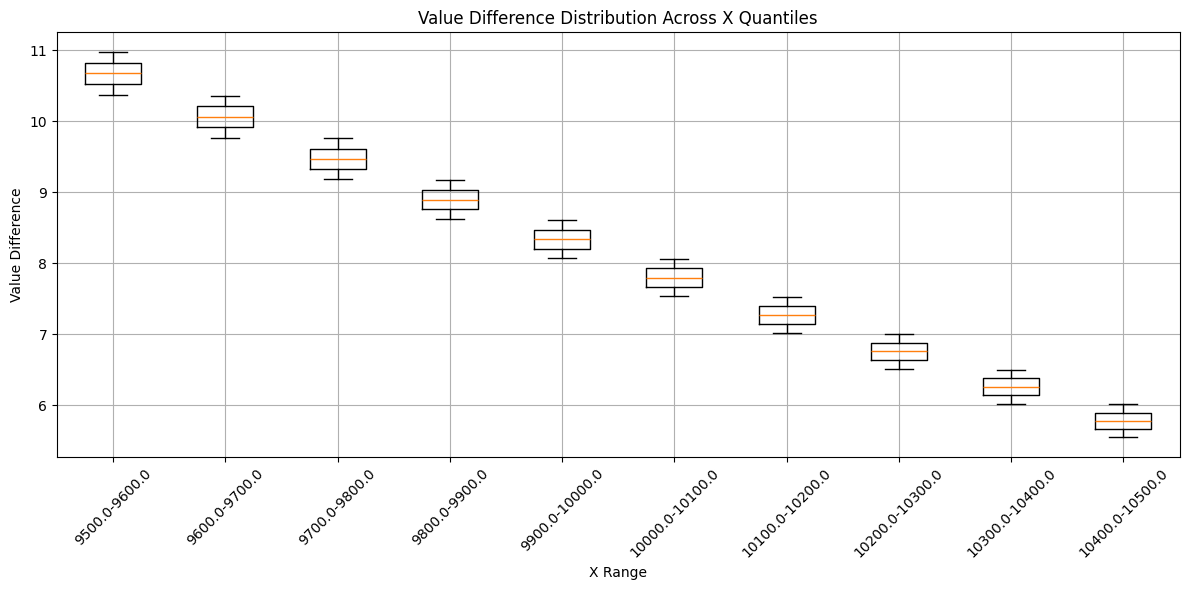

In [5]:
# Create a figure
plt.figure(figsize=(12, 6))

# Box plot of value differences across x quantiles
x_quantiles = pd.qcut(df['x'], 10, labels=[f'Q{i+1}' for i in range(10)])
plt.boxplot([df[x_quantiles == q]['value_diff'] for q in x_quantiles.unique()])
plt.xlabel('X Range')
plt.ylabel('Value Difference')
plt.title('Value Difference Distribution Across X Quantiles')
plt.grid(True)

# Add quantile range information
x_ranges = pd.qcut(df['x'], 10)
x_range_labels = [f'{q.left:.1f}-{q.right:.1f}' for q in x_ranges.unique()]
plt.xticks(range(1, 11), x_range_labels, rotation=45)

plt.tight_layout()
plt.show()

In [6]:
print(df.to_markdown())

|     |   state_idx |        p |        x |        y |   immediate_reward |   incoming_fee |   outgoing_fee |   incoming_value |   outgoing_value |   value_diff |
|----:|------------:|---------:|---------:|---------:|-------------------:|---------------:|---------------:|-----------------:|-----------------:|-------------:|
|   0 |           0 | 1.10803  |  9500    | 10526.3  |            21052.6 |        141.564 |        279.259 |          21035.3 |          21046.3 |     10.9785  |
|   1 |           1 | 1.10757  |  9502    | 10524.1  |            21048.2 |        141.534 |        279.2   |          21031   |          21042   |     10.9648  |
|   2 |           2 | 1.1071   |  9504.01 | 10521.9  |            21043.8 |        141.505 |        279.141 |          21026.6 |          21037.6 |     10.9531  |
|   3 |           3 | 1.10663  |  9506.01 | 10519.7  |            21039.3 |        141.475 |        279.082 |          21022.3 |          21033.2 |     10.9434  |
|   4 |           4 | 

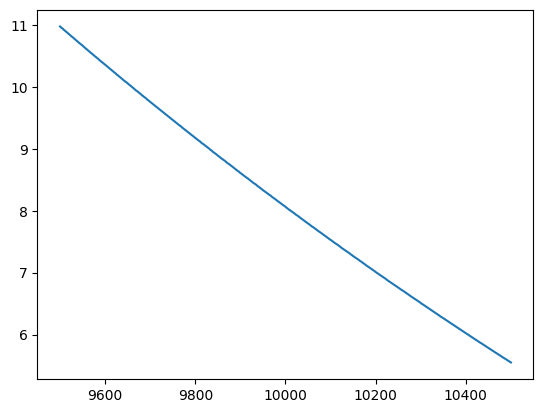

In [7]:
import matplotlib.pyplot as plt

plt.plot(df['x'], df['value_diff'])

In [8]:
10487.9755859375 * 9534.728515625

99999999.8904171

In [9]:
10000 ** 2 /10487.9755859375 

9534.728526073432

In [10]:
18712.16015625 * 5344.119140625

100000013.25345612

In [11]:

10000 * (0.2570364475250244/(1-0.1))**(1/2)

5344.118756217743

In [12]:
10000 / (0.2570364475250244/(1-0.1))**(1/2)

18712.159022224685

In [13]:
5344.118756217743 * 18712.159022224685

100000000.0

In [14]:
# use torch 

L = 10000
gamma = 0.1
import torch
p = torch.tensor(0.2570364475250244, dtype=torch.float64)

print(f"p: {p}")
results = L * torch.sqrt(p / (1 - gamma))
print(f"results: {results}")
print(L * torch.sqrt(p / (1 - gamma)))





p: 0.2570364475250244
results: 5344.118756217743
tensor(5344.1188, dtype=torch.float64)


In [15]:
import torch
import numpy as np

# Parameters
L = 10000
gamma = 0.1

# Using torch with double precision (float64)
p_torch = torch.tensor(0.2570364475250244, dtype=torch.float64)
print(f"p (torch): {p_torch}")
result_torch = L * torch.sqrt(p_torch / (1 - gamma))
print(f"Result (torch): {result_torch}")

# Using numpy
p_numpy = 0.2570364475250244
result_numpy = np.sqrt(p_numpy / (1 - gamma)) * L
print(f"Result (numpy): {result_numpy}")

p (torch): 0.2570364475250244
Result (torch): 5344.118756217743
Result (numpy): 5344.118756217743
